###  Photosynthetic Electron Transport Chain mathematical model (version from 2014)
With this Notebook you can reproduce the results presented in 

Oliver Ebenhöh, Geoffrey Fucile, Giovanni Finazzi, Jean‐David Rochaix and Michel Goldschmidt‐Clermont (2014)
"Short-term acclimation of the photosynthetic electron transfer chain to changing light: a mathematical model"
*Phil Trans Roy Soc B* 369 doi:10.1098/rstb.2013.0223

The mathematical model of the photosynthetic electron transport chain has been implemented using the modelbase1.0 software developed at the University of Dusseldorf.

#### The model has been implemented using the modelbase1.0 version

In [1]:
# I want to have my figures active here (e.g., zoom into my plots)
%matplotlib notebook 

In [2]:
from modelbase.ode import Model, Simulator

import numpy as np
import matplotlib.pyplot as plt

Could not find GLIMDA.


## Create the model

I start with defining the compound list, as this is how I am thinking about model's structure: state variabels that describe the dynamics od the system.

In [3]:
variables = [
        "PQ",  # oxidised plastoquinone
        "PC",  # oxidised plastocyan
        "Fd",  # oxidised ferrodoxin
        "ATP",  # stromal concentration of ATP
        "NADPH",  # stromal concentration of NADPH
        "H",  # lumenal protons
        "LHC", #non-phosphorylated LHC
]

Next I pass the dictionary/dictionaries of parameters

In [4]:
p = {
    "PSIItot": 2.5, # [mmol/molChl] total concentration of PSII
    "PSItot": 2.5,
    "PQtot": 17.5, # [mmol/molChl]
    "PCtot": 4., # Bohme1987 but other sources give different values - seems to depend greatly on organism and conditions
    "Fdtot": 5., # Bohme1987
    "Ctot": 2.5, #source unclear (Schoettler says 0.4...?, but plausible to assume that complexes (PSII,PSI,b6f) have approx. same abundance)
    "NADPtot": 25., # estimate from ~ 0.8 mM, Heineke1991
    "APtot": 60., # [mmol/molChl] Bionumbers ~2.55mM (=81mmol/molChl) (FIXME: Soma had 50)

    # parameters associated with photosystem II
    "kH": 0.,
    "kH0": 5e8, # base quenching" after calculation with Giovanni
    "kF": 6.25e7, # 6.25e7 fluorescence 16ns
    "k1": 5e9, # excitation of Pheo / charge separation 200ps
    "k1rev": 1e10,
    "k2": 5e9,

    # parameters associated with photosystem I
    "kStt7": 0.0035, # [s-1] fitted to the FM dynamics
    "kPph1": 0.0013, # [s-1] fitted to the FM dynamics
    "KM_ST": 0.2, # Switch point (half-activity of Stt7) for 20% PQ oxidised (80% reduced)
    "n_ST": 2., # Hill coefficient of 4 -> 1/(2.5^4)~1/40 activity at PQox=PQred
    "staticAntI": 0.2,     # corresponds to PSI - LHCI supercomplex, when chlorophyll decreases more relative fixed antennae
    "staticAntII": 0.,     # corresponds to PSII core

     # ATP and NADPH parameters
    "kATPsynth": 20.,    # taken from MATLAB
    "kATPcons": 10.,     # taken from MATLAB
    "ATPcyt": 0.5,       # only relative levels are relevant (normalised to 1) to set equilibrium
    "Pi_mol": 0.01,
    "DeltaG0_ATP": 30.6, # 30.6kJ/mol / RT
    "HPR": 14./3.,  #Vollmar et al. 2009 (after Zhu et al. 2013)
    "kNADPHcons": 15., # taken from MATLAB
    "NADPHcyt": 0.5, # only relatice levels

    # global conversion factor of PFD to excitation rate
    #"cPFD": 4. # [m^2/mmol PSII]

    # pH and protons
    "pHstroma": 7.8,
    "kLeak": 0.010, # [1/s] leakage rate -- inconsistency with Kathrine
    "bH": 100., # proton buffer: ratio total / free protons

    # rate constants
    "kPQred": 250., # [1/(s*(mmol/molChl))]
    "kCytb6f": 2.5, # a rough estimate: transfer PQ->cytf should be ~10ms
    "kPTOX": .01, # ~ 5 electrons / seconds. This gives a bit more (~20)
    "kPCox": 2500., # a rough estimate: half life of PC->P700 should be ~0.2ms
    "kFdred": 2.5e5, # a rough estimate: half life of PC->P700 should be ~2micro-s
    "kcatFNR": 500., # Carrillo2003 (kcat~500 1/s)
    "kcyc": 1.,

    "O2ext": 8., # corresponds to 250 microM cor to 20%
    "kNDH": .002, # re-introduce e- into PQ pool. Only positive for anaerobic (reducing) condition
    "kNh": 0.05,
    "kNr": 0.004,
    "NPQsw": 5.8,
    "nH": 5.,

    "EFNR": 3., # Bohme1987
    "KM_FNR_F": 1.56, # corresponds to 0.05 mM (Aliverti1990)
    "KM_FNR_N": 0.22, # corresponds to 0.007 mM (Shin1971 Aliverti2004)

    # standard redox potentials (at pH=0) in V
    "E0_QA": -0.140,
    "E0_PQ": 0.354,
    "E0_cytf": 0.350,
    "E0_PC": 0.380,
    "E0_P700": 0.480,
    "E0_FA": -0.550,
    "E0_Fd": -0.430,
    "E0_NADP": -0.113,

    # physical constants
    "F": 96.485, # Faraday constant
    "R": 8.3e-3, # universal gas constant
    "T": 298., # Temperature in K - for now assumed to be constant at 25 C

    # light
    "pfd": 100.,
    "Ton": 500.,
    "Toff": 1800,
    "dT": 120,
    
    "ox": True,
    }


### Here we define the model object

In [5]:
# modelbase 0.4.0
m = Model(parameters=p, compounds=variables)

In [6]:
m.get_compounds()

['PQ', 'PC', 'Fd', 'ATP', 'NADPH', 'H', 'LHC']

From now on we will be adding various components to the model, such as derived parameters, that can be calculated from the provided parameters, derived variables, which can be calculated from other variables and reactions.

In [7]:
# ====================================================================== #
# Composed parameters #
m.add_derived_parameter(
    parameter_name="RT", function=lambda r, t: r * t, parameters=["R", "T"]
)

m.add_derived_parameter(
    parameter_name="dG_pH", function=lambda r, t: np.log(10) * r * t, parameters=["R", "T"]
)

m.add_derived_parameter(
    parameter_name="Hstroma", function=lambda pHstroma: 3.2e4*10**(-pHstroma), parameters=["pHstroma"]
)

m.add_derived_parameter(
    parameter_name="kProtonation", function=lambda Hstroma: 4e-3 / Hstroma, parameters=["Hstroma"]
)

def keq_PQred(E0_QA, F, E0_PQ, pHstroma, dG_pH, RT):
    DG1 = -E0_QA * F
    DG2 = -2 * E0_PQ * F
    DG = -2 * DG1 + DG2 + 2 * pHstroma * dG_pH
    K = np.exp(-DG/RT)
    return K

m.add_derived_parameter(
    parameter_name="Keq_PQred", function=keq_PQred, parameters=["E0_QA", "F", "E0_PQ", "pHstroma", "dG_pH", "RT"]
)

def Keq_cyc(E0_Fd, F, E0_PQ, pHstroma, dG_pH, RT):
    DG1 = -E0_Fd * F
    DG2 = -2 * E0_PQ * F
    DG = -2 * DG1 + DG2 + 2 * dG_pH * pHstroma
    K = np.exp(-DG/RT)
    return K

m.add_derived_parameter(
    parameter_name="Keq_cyc", function=Keq_cyc, parameters=["E0_Fd", "F", "E0_PQ", "pHstroma", "dG_pH", "RT"]
)              

def Keq_FAFd(E0_FA, F, E0_Fd, RT):
    DG1 = -E0_FA * F
    DG2 = -E0_Fd * F
    DG = -DG1 + DG2
    K = np.exp(-DG/RT)
    return K
               
m.add_derived_parameter(
    parameter_name="Keq_FAFd", function=Keq_FAFd, parameters=["E0_FA", "F", "E0_Fd", "RT"]
)               

def Keq_PCP700(E0_PC, F, E0_P700, RT):
    DG1 = -E0_PC * F
    DG2 = -E0_P700 * F
    DG = -DG1 + DG2
    K = np.exp(-DG/RT)
    return K

m.add_derived_parameter(
    parameter_name="Keq_PCP700", function=Keq_PCP700, parameters=["E0_PC", "F", "E0_P700", "RT"]
)               

def Keq_FNR(E0_Fd, F, E0_NADP, pHstroma, dG_pH, RT):
    DG1 = -E0_Fd * F
    DG2 = -2 * E0_NADP * F
    DG = -2 * DG1 + DG2 + dG_pH * pHstroma
    K = np.exp(-DG/RT)
    return K

m.add_derived_parameter(
    parameter_name="Keq_FNR", function=Keq_FNR, parameters=["E0_Fd", "F", "E0_NADP", "pHstroma", "dG_pH", "RT"]
) 

def Keq_ATP(pH, DeltaG0_ATP, dG_pH, HPR, pHstroma, Pi_mol, RT):
    DG = DeltaG0_ATP - dG_pH * HPR * (pHstroma - pH)
    Keq = Pi_mol * np.exp(-DG/RT)
    return Keq

def Keq_cytb6f(pH, F, E0_PQ, E0_PC, pHstroma, RT, dG_pH):
    DG1 = -2 * F * E0_PQ
    DG2 = -F * E0_PC
    DG = - (DG1 + 2*dG_pH * pH) + 2 * DG2 + 2*dG_pH * (pHstroma - pH)
    Keq = np.exp(-DG/RT)
    return Keq


In [8]:
def calculate_pHstroma(x):
    return (-np.log(x*(3.2e-5))/np.log(10))    

def calculate_pHinv(x):
    return (4e3*10**(-x))

def light(pfd):
    '''
    :return: light intensity at certain point of time. 
    Typical PAM light function
    '''
    return pfd

In [9]:
def pqmoiety(PQ, pqtot):
    return pqtot - PQ

m.add_algebraic_module(
    module_name="pq_alm",
    function=pqmoiety,
    compounds=["PQ"],
    derived_compounds=["PQred"],
    modifiers=None,
    parameters=["PQtot"],
)

def pcmoiety(PC, pctot):
    return pctot - PC

m.add_algebraic_module(
    module_name="pc_alm",
    function=pcmoiety,
    compounds=["PC"],
    derived_compounds=["PCred"],
    parameters=["PCtot"],
)

def fdmoiety(Fd, fdtot):
    return fdtot - Fd

m.add_algebraic_module(
    module_name="fd_alm",
    function=fdmoiety,
    compounds=["Fd"],
    derived_compounds=["Fdred"],
    parameters=["Fdtot"],
)

def adpmoiety(ATP, atptot):
    return atptot - ATP

m.add_algebraic_module(
    module_name="adp_alm",
    function=adpmoiety,
    compounds=["ATP"],
    derived_compounds=["ADP"],
    parameters=["APtot"],
)

def nadpmoiety(NADPH, nadptot):
    return nadptot - NADPH

m.add_algebraic_module(
    module_name="nadp_alm",
    function=nadpmoiety,
    compounds=["NADPH"],
    derived_compounds=["NADP"],
    modifiers=None,
    parameters=["NADPtot"],
)

def lhcmoiety(LHC):
    return 1 - LHC

m.add_algebraic_module(
    module_name="lhc_alm",
    function=lhcmoiety,
    compounds=["LHC"],
    derived_compounds=["LHCp"]
)

def ps2crosssection(LHC, staticAntII, staticAntI):
    """ calculates the cross section of PSII """
    cs = staticAntII + (1 - staticAntII - staticAntI) * LHC
    return cs

m.add_algebraic_module(
    module_name="ps2crosssection",
    function=ps2crosssection,
    compounds=["LHC"],
    derived_compounds=["ps2cs"],
    modifiers=None,
    parameters=["staticAntII", "staticAntI"],
)

def ps2states(PQ, PQred, ps2cs, PSIItot, k2, kF, _kH, kH0, Keq_PQred, kPQred, pfd):
    L = ps2cs * light(pfd)
    kH = kH0 
    k3p = kPQred * PQ
    k3m = kPQred * PQred / Keq_PQred
   
    Bs = []

    
    if isinstance(kH, float) and isinstance(PQ, np.ndarray):
        kH = np.repeat(kH, len(PQ))
      
    
    for L, kH, k3p, k3m in zip(L, kH, k3p, k3m):
        M = np.array(
            [
                [-L - k3m, kH + kF, k3p, 0],
                [L, -(kH + kF + k2), 0, 0],
                [0, 0, L, -(kH + kF)],
                [1, 1, 1, 1],
            ]
        )
        A = np.array([0, 0, 0, PSIItot])
        B0, B1, B2, B3 = np.linalg.solve(M, A)
        Bs.append([B0, B1, B2, B3])
    return np.array(Bs).T


m.add_algebraic_module(
    module_name="ps2states",
    function=ps2states,
    compounds=["PQ", "PQred", "ps2cs"],
    derived_compounds=["B0", "B1", "B2", "B3"],
    parameters=["PSIItot", "k2", "kF", "kH", "kH0", "Keq_PQred", "kPQred", "pfd"],
)

def ps1states(PC, PCred, Fd, Fdred, LHC, ps2cs, PSItot, kFdred, Keq_FAFd, Keq_PCP700, kPCox, pfd):
    """ 
    QSSA calculates open state of PSI
    depends on reduction states of plastocyanin and ferredoxin
    C = [PC], F = [Fd] (ox. forms)
    accepts: light, y as an array of arrays
    returns: array of PSI open
    """
    L = (1-ps2cs) * light(pfd)

    A1 = PSItot / (1 + L/(kFdred * Fd) + (1 + Fdred/(Keq_FAFd * Fd))
                      * (PC/(Keq_PCP700 * PCred)
                         + L/(kPCox * PCred))
    )
    return A1

m.add_algebraic_module(
    module_name="ps1states",
    function=ps1states,
    compounds=["PC", "PCred", "Fd", "Fdred", "LHC", "ps2cs"],
    derived_compounds=["A1"],
    parameters=["PSItot", "kFdred", "Keq_FAFd", "Keq_PCP700", "kPCox", "pfd"],
)

def fluorescence(B0, B2, ps2cs, k2, kF, kH, kH0):
    fluo = (ps2cs * kF * B0) / (kF + kH0 + k2 + kH) + (ps2cs * kF * B2) / (kF + kH0+ kH)
    return fluo

m.add_algebraic_module(
    module_name="fluorescence",
    function=fluorescence,
    compounds=["B0", "B2", "ps2cs"],
    derived_compounds=["Fluo"],
    modifiers=None,
    parameters=["k2","kF", "kH", "kH0"]
)

def calculate_pH(x):
    return (-np.log(x*(2.5e-4))/np.log(10))

m.add_algebraic_module(
    module_name="calculate_pH",
    function=calculate_pH,
    compounds=["H"],
    derived_compounds=["pH"],
    modifiers=None
)

I found it critical to introduce each occupation state of PSII as a new variable, and hence algebraic mode

In [10]:
# Rate of electron flow through the photosystems.
# Calling algebraic modules calculating excited states of each photosystem
def vPS2(B1, k2):
    """ reaction rate constant for photochemistry """
    v = 0.5 * k2 * B1
    return v

m.add_reaction(
    rate_name='vPS2',
    function=vPS2,
    stoichiometry= {"PQ":-1, "H": 2/m.get_parameter("bH")},
    dynamic_variables=["B1"],
    parameters=["k2"],
    reversible=True,
)

def vPS1(A, ps2cs, pfd):
    """ reaction rate constant for open PSI """
    L = (1-ps2cs) * light(pfd)
    v = L * A
    return v

m.add_reaction(
    rate_name='vPS1',
    function=vPS1,
    stoichiometry={"Fd": -1, "PC": 1},
    dynamic_variables=["A1", "ps2cs"],
    parameters=["pfd"],
    reversible=True,
)


In [11]:
###############################################################################
# Reaction rates
###############################################################################
def _oxygen(time, ox, O2ext, kNDH, Ton, Toff):
    """ return oxygen and NDH concentration as a function of time
    used to simulate anoxia conditions as in the paper"""
    if ox == True:
        ''' by default we assume constant oxygen supply'''
        return O2ext, kNDH
    else:
        if time<Ton or time>Toff:
            return O2ext, 0
        else:
            return 0, kNDH

##############################################################################
def oxygen(time, ox, O2ext, kNDH, Ton, Toff):
    """ return oxygen and NDH concentration as a function of time
    used to simulate anoxia conditions as in the paper"""
    if isinstance(time, (int, float)):
        return np.array(_oxygen(time, ox, O2ext, kNDH, Ton, Toff))
    else:
        return np.array(
            [
                _oxygen(t, ox, O2ext, kNDH, Ton, Toff)
                for t in time
            ]
        ).T     
        
def vPTOX(Pred, time, kPTOX, ox, O2ext, kNDH, Ton, Toff):
    """ calculates reaction rate of PTOX """
    v = Pred * kPTOX * oxygen(time, ox, O2ext, kNDH, Ton, Toff)[0] 
    return v

m.add_reaction(
    rate_name='vPTOX',
    function=vPTOX,
    stoichiometry= {"PQ": 1},
    modifiers=["PQred", "time"],
    parameters=["kPTOX", "ox", "O2ext", "kNDH", "Ton", "Toff"],
    reversible=False,
)


def vNDH(Pox, time, ox, O2ext, kNDH, Ton, Toff):
    """ 
    calculates reaction rate of PQ reduction under absence of oxygen
    can be mediated by NADH reductase NDH
    """
    v = oxygen(time, ox, O2ext, kNDH, Ton, Toff)[1] * Pox
    return v

m.add_reaction(
    rate_name='vNDH',
    function=vNDH,
    stoichiometry=  {"PQ":-1},
    modifiers=["time"],
    parameters=["ox", "O2ext", "kNDH", "Ton", "Toff"],
    reversible=False,
)


def vB6f(PC, Pox, H, Pred, PCred, pH, kCytb6f, F, E0_PQ, E0_PC, pHstroma, RT, dG_pH):
    """ calculates reaction rate of cytb6f """
    Keq = Keq_cytb6f(pH, F, E0_PQ, E0_PC, pHstroma, RT, dG_pH)
    v = np.maximum(kCytb6f * (Pred * PC**2 - (Pox * PCred**2)/Keq), -kCytb6f)
    return v

m.add_reaction(
    rate_name='vB6f',
    function=vB6f,
    stoichiometry={"PC": -2, "PQ": 1, "H": 4/100},
    modifiers=["PQred", "PCred", "pH"],
    parameters=["kCytb6f", "F", "E0_PQ", "E0_PC", "pHstroma", "RT", "dG_pH"],
    reversible=True,
)

def vCyc(Pox, Fdred, kcyc):
    """
    calculates reaction rate of cyclic electron flow
    considered as practically irreversible
    """
    v = kcyc * ((Fdred**2) * Pox)
    return v

m.add_reaction(
    rate_name='vCyc',
    function=vCyc,
    stoichiometry=  {"PQ": -1, "Fd": 2},
    dynamic_variables=["PQ","Fdred"],
    parameters=["kcyc"],
    reversible=True,
)

def vFNR(Fd, Fdred, NADPH, NADP, KM_FNR_F, KM_FNR_N, EFNR, kcatFNR, Keq_FNR):
    """
    Reaction rate mediated by the Ferredoxin—NADP(+) reductase (FNR)
    Kinetic: convenience kinetics Liebermeister and Klipp, 2006
    Compartment: lumenal side of the thylakoid membrane
    Units:
    Reaction rate: mmol/mol Chl/s
    [F], [Fdred] in mmol/mol Chl/s
    [NADPH] in mM
    """
    fdred = Fdred/KM_FNR_F
    fdox = Fd/KM_FNR_F
    nadph = (NADPH)/KM_FNR_N  # NADPH requires conversion to mmol/mol of chlorophyll 
    nadp = (NADP)/KM_FNR_N # NADP requires conversion to mmol/mol of chlorophyll 
    v = (EFNR * kcatFNR *
        ((fdred**2) * nadp - ((fdox**2) * nadph) / Keq_FNR) /
        ((1+fdred+fdred**2) * (1+nadp) + (1+fdox+fdox**2) * (1+nadph) - 1))
    return v

m.add_reaction(
    rate_name='vFNR',
    function=vFNR,
    stoichiometry=  {"Fd": 2, "NADPH": 1},
    dynamic_variables=["Fd", "Fdred", "NADPH", "NADP"],
    parameters=["KM_FNR_F", "KM_FNR_N", "EFNR", "kcatFNR", "Keq_FNR"],
    reversible=False,
)
         

def vLeak(H, kLeak, pHstroma):
    """ 
    rate of leak of protons through the membrane
    """
    v = kLeak * (H - calculate_pHinv(pHstroma))
    return v


m.add_reaction(
    rate_name='vLeak',
    function=vLeak,
    stoichiometry= {"H": -1/m.get_parameter("bH")},
    modifiers=None,
    parameters=["kLeak", "pHstroma"],
    reversible=False,
)

def vSt12(Ant, Pox, kStt7, PQtot, KM_ST, n_ST):
    """ 
    reaction rate of state transitions from PSII to PSI
    Ant depending on module used corresponds to non-phosphorylated antennae
    or antennae associated with PSII
    """
    kKin = kStt7 * ( 1 / (1 + ((Pox /PQtot)/KM_ST)**n_ST))
    v = kKin * Ant
    return v

m.add_reaction(
    rate_name='vSt12',
    function=vSt12,
    stoichiometry= {"LHC": -1},
    modifiers=["PQ"],
    parameters=["kStt7", "PQtot", "KM_ST", "n_ST"],
    reversible=False,
)

def vSt21(LHCp, kPph1):
    """
    reaction rate of state transitions from PSI to PSII
    """
    v = kPph1 * LHCp
    return v

m.add_reaction(
    rate_name='vSt21',
    function=vSt21,
    stoichiometry= {"LHC": 1},
    dynamic_variables=["LHCp"],
    parameters=["kPph1"],
    reversible=False,
)

def vATPsynthase(ATP, ADP, pH, kATPsynth, DeltaG0_ATP, dG_pH, HPR, pHstroma,Pi_mol, RT):
    """
    Reaction rate of ATP production
    Kinetic: simple mass action with PH dependant equilibrium
    Compartment: lumenal side of the thylakoid membrane
    Units:
    Reaction rate: mmol/mol Chl/s
    [ATP], [ADP] in mM
    """    
    v = kATPsynth * (ADP - ATP / Keq_ATP(pH, DeltaG0_ATP, dG_pH, HPR, pHstroma, Pi_mol, RT)) #* E
    return v

m.add_reaction(
    rate_name='vATPsynthase',
    function=vATPsynthase,
    stoichiometry= {"ATP": 1, "H": -m.get_parameter('HPR')/m.get_parameter('bH')},
    dynamic_variables=["ATP","ADP","pH"],
    parameters=["kATPsynth","DeltaG0_ATP","dG_pH","HPR","pHstroma","Pi_mol","RT"],
    reversible=True,
)

def vATPconsumption(A, kATPcons):
        v = kATPcons * A
        return v
    
m.add_reaction(
    rate_name='vATPconsumption',
    function=vATPconsumption,
    stoichiometry= {"ATP": -1},
    parameters=["kATPcons"],
    reversible=False,
)


def vNADPHconsumption(N, kNADPHcons):
        v = kNADPHcons * N
        return v
    
m.add_reaction(
    rate_name='vNADPHconsumption',
    function=vNADPHconsumption,
    stoichiometry= {"NADPH": -1},
    parameters=["kNADPHcons"],
    reversible=False,
)

To compare now the implemented model with the differential equations I am checking the stoichiometric matrix

In [ ]:
m.get_stoichiometric_matrix()

Ok, I have no idea what was the order of the reaction rates. Fortunately, there is this magic function `m.get_stoichiometric_df()`. How neat is that?

In [13]:
m.get_stoichiometric_df()

vATPconsumption  vATPsynthase  vB6f  vCyc  vFNR  vLeak  \
ATP               -1.0      1.000000  0.00   0.0   0.0   0.00   
Fd                 0.0      0.000000  0.00   2.0   2.0   0.00   
H                  0.0     -0.046667  0.04   0.0   0.0  -0.01   
LHC                0.0      0.000000  0.00   0.0   0.0   0.00   
NADPH              0.0      0.000000  0.00   0.0   1.0   0.00   
PC                 0.0      0.000000 -2.00   0.0   0.0   0.00   
PQ                 0.0      0.000000  1.00  -1.0   0.0   0.00   

       vNADPHconsumption  vNDH  vPS1  vPS2  vPTOX  vSt12  vSt21  
ATP                  0.0   0.0   0.0  0.00    0.0    0.0    0.0  
Fd                   0.0   0.0  -1.0  0.00    0.0    0.0    0.0  
H                    0.0   0.0   0.0  0.02    0.0    0.0    0.0  
LHC                  0.0   0.0   0.0  0.00    0.0   -1.0    1.0  
NADPH               -1.0   0.0   0.0  0.00    0.0    0.0    0.0  
PC                   0.0   0.0   1.0  0.00    0.0    0.0    0.0  
PQ                   0.0  -1.0   0.0 -1.00    1.0    0.0    0.0

The model is complete. Now using Simulator class we can create an object that is 'integratable'. 

In [14]:
s = Simulator(m)

# Set initial conditions using dictionary
y0 = {#"B":  m.get_parameter("PSIItot"),  #photosystem II protein concentration
      "PQ":p['PQtot'],  # oxidised plastoquinone
      "PC":0.0202,  # oxidised plastocyan
      "Fd":5.0,  # oxidised ferrodoxin
      "ATP": 0.0,# stromal concentration of ATP
      "NADPH": 0.0,  # stromal concentration of NADPH
      "H": calculate_pHinv(7.2),  # lumenal protons
      "LHC": 0.9}

In [22]:
m.get_full_concentration_dict(y0)

{'PQ': array([17.5]),
 'PC': array([0.0202]),
 'Fd': array([5.]),
 'ATP': array([0.]),
 'NADPH': array([0.]),
 'H': array([0.00025238]),
 'LHC': array([0.9]),
 'time': array([0.]),
 'PQred': array([0.]),
 'PCred': array([3.9798]),
 'Fdred': array([0.]),
 'ADP': array([60.]),
 'NADP': array([25.]),
 'LHCp': array([0.1]),
 'ps2cs': array([0.72]),
 'B0': array([2.49999963]),
 'B1': array([3.23595458e-13]),
 'B2': array([3.6982338e-07]),
 'B3': array([4.73373927e-19]),
 'A1': array([2.49974334]),
 'Fluo': array([0.02022475]),
 'pH': array([7.2])}

In [15]:
# check if the starting fluxes sound plausible
m.get_fluxes_df(y0)

vPS2       vPS1  vPTOX   vNDH          vB6f  vCyc  vFNR     vLeak  \
0  79.719588  69.794855    0.0  0.035 -5.751046e-12   0.0   0.0  0.000002   

      vSt12    vSt21  vATPsynthase  vATPconsumption  vNADPHconsumption  
0  0.000121  0.00013        1200.0              0.0                0.0

## Reproduce PAM experiment (Fig 1. from the paper, upper pannel)

In [16]:
s = Simulator(m)

s.initialise(y0)
s.update_parameters({'Ton': 270, 'Toff':900, 'dT': 90})
                    
t=0
Tmax=1800
while t < Tmax :   
    #turn on the saturating pulse of light of Tflash length
    if t%s.model.get_parameter('dT') == 0:
        s.update_parameter('pfd', 5000)
        s.simulate(t+0.8, steps=1000)
    else:
        #switch on the light except for the dark period
        #t+dT-Tflash is the time to the next flash
        if t< s.model.get_parameter('Ton') or t>s.model.get_parameter('Toff'):
            s.update_parameter('pfd', 0.0001)
        else:
            #put the actinic light
            s.update_parameter('pfd', 100)
        new_t = t+s.model.get_parameter('dT')-0.8
        s.simulate(new_t, **{"atol":1.0e-10})  #I needed to make it smaller from the default, otherwise integration problems  
    t = s.get_time()[-1]           
                

<IPython.core.display.Javascript object>


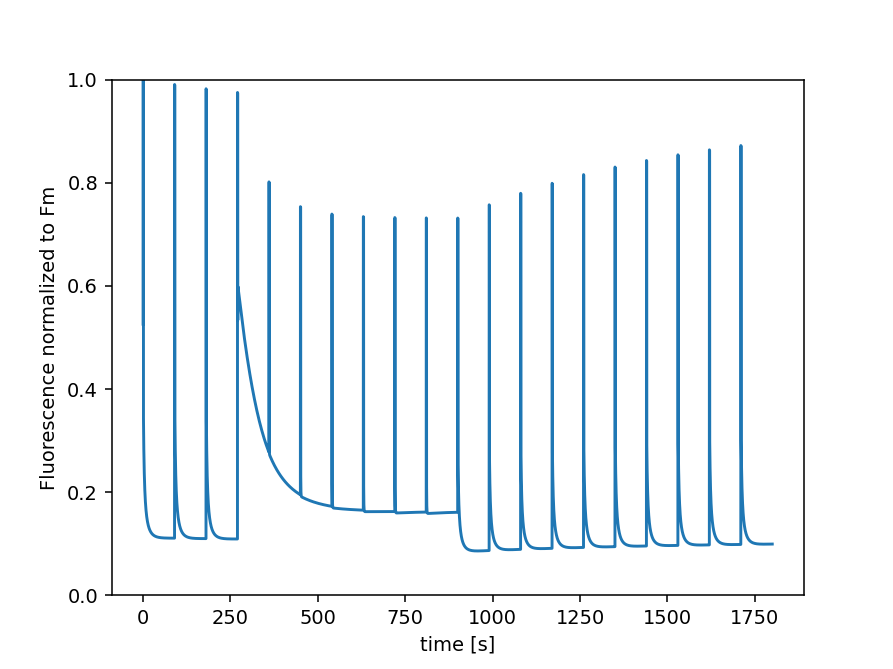

Text(0, 0.5, 'Fluorescence normalized to Fm')

In [17]:
# Needs to be normalized s.plot_selection('Fluo')
f = max(s.get_variable('Fluo'))
plt.figure()
plt.plot(s.get_time(), s.get_variable('Fluo')/f)
plt.xlabel('time [s]')
plt.ylim(0,1)
plt.ylabel('Fluorescence normalized to Fm')

### Supplementary FigureS1 
Simulated temporal evolution of the plastoquinone redox state (red) and the antenna cross‐section of PSII (blue) as a response to light‐induced state transitions.

<IPython.core.display.Javascript object>


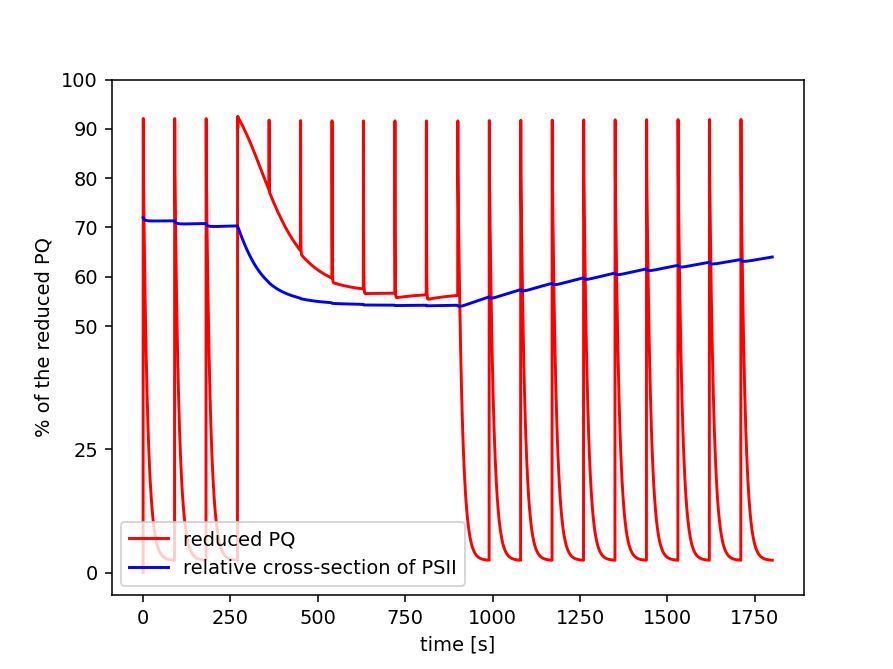

In [18]:
plt.figure()
plt.plot(s.get_time(), s.get_variable('PQred')/s.model.get_parameter('PQtot'), 'r', label='reduced PQ')
plt.plot(s.get_time(), s.get_variable('ps2cs'), 'b', label='relative cross-section of PSII')

plt.xlabel('time [s]')
plt.yticks([0, 0.25, .5, .6, .7, .8, .9, 1],[0, 25, 50, 60, 70, 80, 90, 100])
plt.ylabel('% of the reduced PQ')
plt.legend()

## Reproduce PAM experiment (Fig 1. from the paper, lower pannel, anoxic conditions)

In [19]:
# Simulation with switched off oxygen, not light
s = Simulator(m)

s.initialise(y0)
s.update_parameters({'pfd':0.001, 'ox': False, 'Ton': 270., 'Toff':900., 'dT': 90.})
                    
t=0
Tmax=1800
while t < Tmax :   
    #turn on the saturating pulse of light of Tflash length
    if t%s.model.get_parameter('dT') == 0:
        s.update_parameter('pfd', 5000)
        s.simulate(t+0.8, **{"atol":1.0e-10})
    else:
        s.update_parameter('pfd', 0.001)
        new_t = t+s.model.get_parameter('dT')-0.8
        s.simulate(new_t, **{"atol":1.0e-11})  #I needed to make it smaller from the default, otherwise integration problems  
    t = s.get_time()[-1]   

<IPython.core.display.Javascript object>


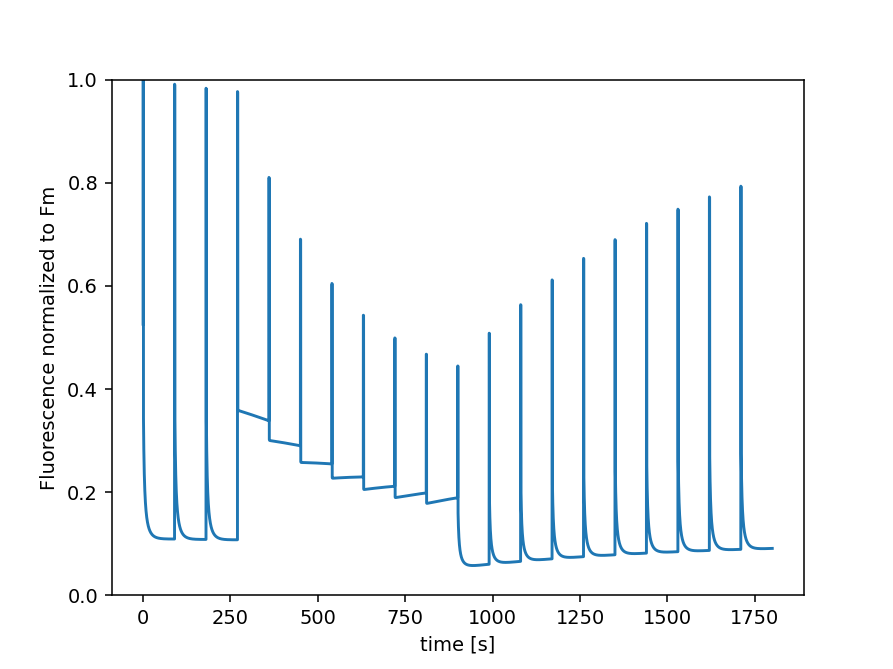

Text(0, 0.5, 'Fluorescence normalized to Fm')

In [20]:
# Needs to be normalized s.plot_selection('Fluo')
f = max(s.get_variable('Fluo'))
plt.figure()
plt.plot(s.get_time(), s.get_variable('Fluo')/f)
plt.xlabel('time [s]')
plt.ylim(0,1)
plt.ylabel('Fluorescence normalized to Fm')

In [21]:
s.get_fluxes_df()

vPS2         vPS1         vPTOX  vNDH          vB6f  \
0.000000e+00  2325.145050  3064.977785  0.000000e+00   0.0 -5.751046e-12   
2.831174e-14  2325.145050  3064.977785  5.266259e-12   0.0 -5.683894e-12   
2.831458e-10  2325.145009  3064.977689  5.266839e-08   0.0  6.658948e-10   
1.229613e-09  2325.144873  3064.977371  2.287223e-07   0.0  2.911833e-09   
2.176080e-09  2325.144736  3064.977052  4.047761e-07   0.0  5.159061e-09   
3.122547e-09  2325.144600  3064.976733  5.808300e-07   0.0  7.407580e-09   
4.069014e-09  2325.144463  3064.976414  7.568838e-07   0.0  9.657388e-09   
6.117198e-09  2325.144168  3064.975724  1.137870e-06   0.0  1.453046e-08   
9.936654e-09  2325.143617  3064.974438  1.848332e-06   0.0  2.363393e-08   
1.764490e-08  2325.142505  3064.971841  3.282155e-06   0.0  4.207024e-08   
2.926850e-08  2325.140828  3064.967925  5.444276e-06   0.0  7.003356e-08   
4.089210e-08  2325.139151  3064.964009  7.606395e-06   0.0  9.819264e-08   
5.251569e-08  2325.137474  3064.960094  9.768512e-06   0.0  1.265480e-07   
6.413929e-08  2325.135797  3064.956178  1.193063e-05   0.0  1.551002e-07   
7.576288e-08  2325.134120  3064.952262  1.409274e-05   0.0  1.838496e-07   
8.738648e-08  2325.132443  3064.948346  1.625485e-05   0.0  2.127969e-07   
1.053562e-07  2325.129850  3064.942292  1.959741e-05   0.0  2.579391e-07   
1.233259e-07  2325.127258  3064.936238  2.293997e-05   0.0  3.035572e-07   
1.412957e-07  2325.124665  3064.930184  2.628252e-05   0.0  3.496532e-07   
1.592654e-07  2325.122073  3064.924129  2.962507e-05   0.0  3.962288e-07   
1.772351e-07  2325.119480  3064.918074  3.296761e-05   0.0  4.432861e-07   
2.155271e-07  2325.113956  3064.905172  4.009027e-05   0.0  5.451766e-07   
2.393090e-07  2325.110525  3064.897159  4.451392e-05   0.0  6.095709e-07   
2.630910e-07  2325.107094  3064.889145  4.893757e-05   0.0  6.748236e-07   
2.868729e-07  2325.103663  3064.881131  5.336121e-05   0.0  7.409391e-07   
3.106548e-07  2325.100232  3064.873117  5.778484e-05   0.0  8.079218e-07   
3.344368e-07  2325.096800  3064.865103  6.220847e-05   0.0  8.757760e-07   
3.707888e-07  2325.091556  3064.852852  6.897023e-05   0.0  9.811896e-07   
4.071409e-07  2325.086311  3064.840600  7.573197e-05   0.0  1.088666e-06   
4.434929e-07  2325.081067  3064.828348  8.249370e-05   0.0  1.198220e-06   
...                   ...          ...           ...   ...           ...   
1.783140e+03     0.000665     0.001020  4.027417e-03   0.0  1.413386e-04   
1.784091e+03     0.000665     0.001020  3.772278e-03   0.0  1.380027e-04   
1.785041e+03     0.000665     0.001019  3.536070e-03   0.0  1.347818e-04   
1.785991e+03     0.000666     0.001019  3.317398e-03   0.0  1.316776e-04   
1.786941e+03     0.000666     0.001018  3.114970e-03   0.0  1.286917e-04   
1.787558e+03     0.000666     0.001018  2.991596e-03   0.0  1.268158e-04   
1.787953e+03     0.000666     0.001018  2.915976e-03   0.0  1.256443e-04   
1.788227e+03     0.000666     0.001018  2.864834e-03   0.0  1.248424e-04   
1.788501e+03     0.000666     0.001018  2.814818e-03   0.0  1.240505e-04   
1.788775e+03     0.000666     0.001017  2.765905e-03   0.0  1.232687e-04   
1.789049e+03     0.000666     0.001017  2.718071e-03   0.0  1.224969e-04   
1.789323e+03     0.000666     0.001017  2.671292e-03   0.0  1.217354e-04   
1.789597e+03     0.000666     0.001017  2.625545e-03   0.0  1.209839e-04   
1.789871e+03     0.000666     0.001017  2.580807e-03   0.0  1.202426e-04   
1.790145e+03     0.000666     0.001017  2.537056e-03   0.0  1.195114e-04   
1.790419e+03     0.000666     0.001017  2.494271e-03   0.0  1.187904e-04   
1.790693e+03     0.000667     0.001017  2.452430e-03   0.0  1.180796e-04   
1.790967e+03     0.000667     0.001016  2.411513e-03   0.0  1.173790e-04   
1.791385e+03     0.000667     0.001016  2.350728e-03   0.0  1.163281e-04   
1.791804e+03     0.000667     0.001016  2.291983e-03   0.0  1.153010e-04   
1.792223e+03     0.000667     0.001016  2.235210e-03   0.0  1.142977e